In [ ]:
!pip -q install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no gpu")




True
Tesla T4


In [ ]:
UNIVERSE = {
    "Technology": [
        "AAPL", "MSFT", "GOOGL", "GOOG", "NVDA", "META", "ORCL", "CRM",
        "ADBE", "IBM", "INTC", "AMD", "QCOM", "AVGO", "TXN", "CSCO", "AMAT",
        "MU", "NOW", "SNOW", "PANW", "CRWD", "ZS", "ADI", "AMZN"
    ],

    "Healthcare": [
        "JNJ", "UNH", "LLY", "PFE", "MRK", "ABBV", "TMO", "ABT", "DHR", "BMY",
        "AMGN", "GILD", "CVS", "CI", "HUM", "ISRG", "MDT", "SYK", "REGN", "BIIB",
        "VRTX", "ZTS"
    ],

    "Financials": [
        "JPM", "BAC", "WFC", "C", "GS", "MS", "BLK", "SCHW", "AXP", "V",
        "MA", "USB", "PNC", "TFC", "BK", "STT", "MET", "PRU", "AIG", "COF",
        "CME", "ICE"
    ],

    "Industrials": [
        "CAT", "DE", "HON", "GE", "RTX", "LMT", "NOC", "UNP", "CSX", "NSC",
        "UPS", "FDX", "BA", "MMM", "EMR", "ETN", "ITW", "ROK", "PH", "TDG",
        "WM", "GWW"
    ],

    "Consumer Discretionary": [
        "TSLA", "HD", "LOW", "NKE", "MCD", "SBUX", "BKNG", "MAR", "CMG", "YUM",
        "TGT", "DIS", "GM", "F", "RCL", "CCL", "EBAY", "ETSY", "ULTA",
        "TJX", "ROST", "LULU"
    ],

    "Energy": [
    "XOM", "CVX", "COP", "EOG", "SLB", "HAL", "PSX", "MPC", "VLO",
    "OXY", "DVN", "KMI", "WMB", "LNG",
    "APA", "FANG", "EQT", "OKE", "TRGP",
    "BKR"
]
,

    "Consumer Staples": [
        "PG", "KO", "PEP", "WMT", "COST", "CL", "KMB", "GIS", "KHC",
        "MDLZ", "HSY", "SYY", "KR", "WBA", "EL",
        "PM", "MO", "UL", "DG", "KDP", "CPB", "CHD"
    ]
}


In [ ]:
INTENDED_TICKERS = sorted(set(t for sector in UNIVERSE.values() for t in sector))
print("Intended tickers:", len(INTENDED_TICKERS))
INTENDED_TICKERS[:10]


Intended tickers: 155


['AAPL', 'ABBV', 'ABT', 'ADBE', 'ADI', 'AIG', 'AMAT', 'AMD', 'AMGN', 'AMZN']

In [ ]:
start = "2016-01-01"

# Remove known failing ticker(s) for now
TICKERS_FOR_DOWNLOAD = [t for t in INTENDED_TICKERS if t != "WBA"]

data = yf.download(
    tickers=" ".join(TICKERS_FOR_DOWNLOAD),
    start=start,
    auto_adjust=False,      # IMPORTANT: keeps Adj Close available (old behavior)
    group_by="column",
    progress=False,
    threads=True
)

print("data columns top level:", list(data.columns.levels[0]) if hasattr(data.columns, "levels") else "not multiindex")
print("First date:", data.index.min().date(), "Last date:", data.index.max().date())


data columns top level: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
First date: 2016-01-04 Last date: 2026-01-08


In [ ]:
# Prefer Adj Close; if yfinance ever changes again, fall back to Close
if "Adj Close" in data.columns.get_level_values(0):
    adj_close = data["Adj Close"].copy()
else:
    adj_close = data["Close"].copy()

print("Downloaded tickers with price data:", adj_close.shape[1])
print("Date range:", adj_close.index.min().date(), "→", adj_close.index.max().date())


Downloaded tickers with price data: 154
Date range: 2016-01-04 → 2026-01-08


In [ ]:
daily_ret = adj_close.pct_change(fill_method=None)

daily_ret.tail()



Ticker,AAPL,ABBV,ABT,ADBE,ADI,AIG,AMAT,AMD,AMGN,AMZN,...,VLO,VRTX,WFC,WM,WMB,WMT,XOM,YUM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-02,-0.003127,0.003589,-0.008780,-0.047687,0.009366,-0.014962,0.046228,0.043472,0.001008,-0.018716,...,0.015480,-0.002713,0.021459,-0.005962,0.012311,0.012117,0.019196,-0.005222,-0.019340,0.000795
2026-01-05,-0.013837,-0.039815,0.018198,-0.005220,0.012969,0.001305,0.057463,-0.010695,-0.021121,0.028962,...,0.092311,-0.007365,0.012395,0.004762,0.005095,-0.000443,0.022095,-0.001329,0.009929,0.027398
2026-01-06,-0.018334,0.017032,0.010518,0.013361,0.056439,-0.074781,0.041116,-0.030441,0.029465,0.033768,...,-0.012737,0.043627,0.000104,-0.001641,-0.027142,0.014462,-0.034381,0.007452,-0.003277,-0.000155
2026-01-07,-0.007737,0.042379,-0.005791,0.006280,-0.000171,-0.012809,-0.012871,-0.020201,0.034740,0.002615,...,0.031357,0.033669,-0.021786,-0.014196,0.014958,-0.014168,-0.021148,-0.006076,0.041121,-0.028450
2026-01-08,-0.004955,-0.039799,-0.006770,0.002780,0.021407,0.010769,-0.036140,-0.025426,-0.033749,0.019581,...,0.040574,-0.029887,0.013893,0.008751,0.012585,0.003105,0.037303,0.019868,-0.046894,0.009390


In [ ]:
mom_3m  = adj_close.pct_change(63,  fill_method=None)
mom_6m  = adj_close.pct_change(126, fill_method=None)
mom_12m = adj_close.pct_change(252, fill_method=None)

mom_3m.tail(1)


Ticker,AAPL,ABBV,ABT,ADBE,ADI,AIG,AMAT,AMD,AMGN,AMZN,...,VLO,VRTX,WFC,WM,WMB,WMT,XOM,YUM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-08,0.004771,-0.02376,-0.056073,-0.027898,0.261785,-0.067758,0.297375,-0.131092,0.128452,0.093553,...,0.185216,0.115232,0.205351,-0.005808,-0.029039,0.101074,0.087397,0.055994,-0.298098,-0.112888


In [ ]:
vol_3m = daily_ret.rolling(63).std() * np.sqrt(252)

vol_3m.tail(1)



Ticker,AAPL,ABBV,ABT,ADBE,ADI,AIG,AMAT,AMD,AMGN,AMZN,...,VLO,VRTX,WFC,WM,WMB,WMT,XOM,YUM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-08,0.181767,0.257324,0.184746,0.286291,0.316105,0.296423,0.421275,0.560691,0.284222,0.342085,...,0.364685,0.265123,0.253961,0.197357,0.250514,0.237918,0.210728,0.242187,0.397141,0.357653


In [ ]:
last_date = adj_close.index.max()

rankable_tickers = mom_3m.loc[last_date].dropna().index.tolist()

print("Tickers with valid 3m momentum today:", len(rankable_tickers))




Tickers with valid 3m momentum today: 154


In [ ]:
ticker_to_sector = {
    ticker: sector
    for sector, tickers in UNIVERSE.items()
    for ticker in tickers
}

print("Tickers in sector map:", len(ticker_to_sector))



Tickers in sector map: 155


In [ ]:
# which tickers failed to download
INTENDED_TICKERS = sorted(set(t for sector in UNIVERSE.values() for t in sector))
DOWNLOADED_TICKERS = sorted(adj_close.columns)

missing_from_download = sorted(set(INTENDED_TICKERS) - set(DOWNLOADED_TICKERS))
print("Missing from download:", missing_from_download)


Missing from download: ['WBA']


In [ ]:
# Which tickers are missing 3 month momentum today
last_date = adj_close.index.max()
missing_mom3_today = mom_3m.loc[last_date][mom_3m.loc[last_date].isna()].index.tolist()

print("Missing 3m momentum today:", missing_mom3_today)
print("Count:", len(missing_mom3_today))


Missing 3m momentum today: []
Count: 0


In [ ]:
ticker_to_sector = {t: sector for sector, tickers in UNIVERSE.items() for t in tickers}


In [ ]:
rankable_tickers = mom_3m.loc[last_date].dropna().index.tolist()

df_latest = pd.DataFrame({
    "ticker": rankable_tickers,
    "sector": [ticker_to_sector.get(t) for t in rankable_tickers],
    "mom_3m":  mom_3m.loc[last_date, rankable_tickers].values,
    "mom_6m":  mom_6m.loc[last_date, rankable_tickers].values,
    "mom_12m": mom_12m.loc[last_date, rankable_tickers].values,
    "vol_3m":  vol_3m.loc[last_date, rankable_tickers].values,
})

print("df_latest rows:", len(df_latest))
df_latest.head()


df_latest rows: 154


,ticker,sector,mom_3m,mom_6m,mom_12m,vol_3m
0,AAPL,Technology,0.004771,0.222096,0.062088,0.181767
1,ABBV,Healthcare,-0.023760,0.167669,0.287989,0.257324
2,ABT,Healthcare,-0.056073,-0.047081,0.137393,0.184746
3,ADBE,Technology,-0.027898,-0.087203,-0.213693,0.286291
4,ADI,Technology,0.261785,0.229568,0.394925,0.316105


In [ ]:
def zscore(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / (s.std(ddof=0) + 1e-12)

df_latest["mom3_z_sector"] = df_latest.groupby("sector")["mom_3m"].transform(zscore)
df_latest["mom6_z_sector"] = df_latest.groupby("sector")["mom_6m"].transform(zscore)

# Vol penalty normalized across the whole universe
df_latest["vol_z"] = zscore(df_latest["vol_3m"])


In [ ]:
df_latest["QuantScore"] = (
    0.6 * df_latest["mom3_z_sector"] +
    0.4 * df_latest["mom6_z_sector"] -
    0.3 * df_latest["vol_z"]
)

df_latest.sort_values("QuantScore", ascending=False).head(15)[
    ["ticker", "sector", "QuantScore", "mom_3m", "mom_6m", "vol_3m"]
]


,ticker,sector,QuantScore,mom_3m,mom_6m,vol_3m
40,DG,Consumer Staples,2.622898,0.473249,0.295999,0.429280
57,GM,Consumer Discretionary,2.458866,0.512410,0.609041,0.379585
62,HAL,Energy,2.084818,0.353450,0.471973,0.436237
53,FDX,Industrials,1.998754,0.294519,0.309363,0.245480
21,C,Financials,1.851653,0.254592,0.402354,0.247993
98,MU,Technology,1.818712,0.664557,1.659061,0.700008
118,REGN,Healthcare,1.713050,0.422364,0.434958,0.371264
22,CAT,Industrials,1.597611,0.214605,0.499060,0.387598
124,SLB,Energy,1.491882,0.318252,0.231633,0.367584
120,ROST,Consumer Discretionary,1.485481,0.247870,0.453534,0.233821


In [ ]:
# Use adjusted close index (trading days)
dates = adj_close.index

# Take the last trading day of each month
monthly_dates = (
    pd.Series(dates)
      .groupby(dates.to_period("M"))
      .last()
)

print("Number of monthly decision dates:", len(monthly_dates))
monthly_dates[:5], monthly_dates[-5:]


Number of monthly decision dates: 121


(Date
 2016-01   2016-01-29
 2016-02   2016-02-29
 2016-03   2016-03-31
 2016-04   2016-04-29
 2016-05   2016-05-31
 Freq: M, Name: Date, dtype: datetime64[ns],
 Date
 2025-09   2025-09-30
 2025-10   2025-10-31
 2025-11   2025-11-28
 2025-12   2025-12-31
 2026-01   2026-01-08
 Freq: M, Name: Date, dtype: datetime64[ns])

In [ ]:
monthly_dates = monthly_dates[monthly_dates >= "2017-01-31"]

In [ ]:
#Now we will do a backtest to see if this quantitative method works
portfolio_returns = []


In [ ]:
for i in range(len(monthly_dates) - 1):
    asof_date = monthly_dates.iloc[i]
    next_date = monthly_dates.iloc[i + 1]

    # Which stocks are rankable on this date?
    rankable = mom_3m.loc[asof_date].dropna().index.tolist()
    if len(rankable) < 20:
        continue

    df_asof = pd.DataFrame({
        "ticker": rankable,
        "sector": [ticker_to_sector[t] for t in rankable],
        "mom_3m":  mom_3m.loc[asof_date, rankable],
        "mom_6m":  mom_6m.loc[asof_date, rankable],
        "vol_3m":  vol_3m.loc[asof_date, rankable],
    })

    # Make momentum and volatility Z scores grouping by sector
    def zscore(s):
        return (s - s.mean()) / (s.std(ddof=0) + 1e-12)

    df_asof["mom3_z_sector"] = df_asof.groupby("sector")["mom_3m"].transform(zscore)
    df_asof["mom6_z_sector"] = df_asof.groupby("sector")["mom_6m"].transform(zscore)
    df_asof["vol_z"] = zscore(df_asof["vol_3m"])

    df_asof["QuantScore"] = (
        0.6 * df_asof["mom3_z_sector"]
      + 0.4 * df_asof["mom6_z_sector"]
      - 0.3 * df_asof["vol_z"]
    )

    #Select top 20
    top20 = (
        df_asof.sort_values("QuantScore", ascending=False)
               .head(20)["ticker"]
               .tolist()
    )

    # Compute portfolio return over the month
    start_prices = adj_close.loc[asof_date, top20]
    end_prices   = adj_close.loc[next_date, top20]

    monthly_return = (end_prices / start_prices - 1).mean()

    portfolio_returns.append({
        "date": next_date,
        "return": monthly_return
    })


In [ ]:
bt = pd.DataFrame(portfolio_returns).set_index("date")
bt.head(), bt.tail()


(              return
 date                
 2017-02-28  0.020183
 2017-03-31 -0.006838
 2017-04-28  0.018734
 2017-05-31  0.042852
 2017-06-30  0.004237,
               return
 date                
 2025-09-30  0.012934
 2025-10-31  0.014073
 2025-11-28  0.023086
 2025-12-31  0.026316
 2026-01-08  0.048579)

In [ ]:
bt["equity"] = (1 + bt["return"]).cumprod()
bt["equity"].head(), bt["equity"].tail()


(date
 2017-02-28    1.020183
 2017-03-31    1.013207
 2017-04-28    1.032189
 2017-05-31    1.076420
 2017-06-30    1.080981
 Name: equity, dtype: float64,
 date
 2025-09-30    4.687380
 2025-10-31    4.753344
 2025-11-28    4.863079
 2025-12-31    4.991053
 2026-01-08    5.233516
 Name: equity, dtype: float64)

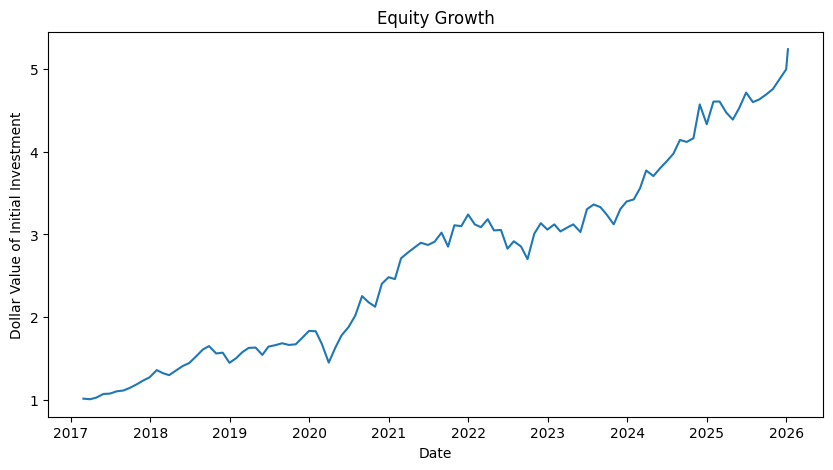

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

equity = bt["equity"]
if isinstance(equity, pd.DataFrame):
    equity = equity.iloc[:, 0]

plt.figure(figsize=(10, 5))
plt.plot(equity.index, equity.values)
plt.title("Equity Growth")
plt.ylabel("Dollar Value of Initial Investment")
plt.xlabel("Date")
plt.show()


In [ ]:
spy_df = yf.download(
    "SPY",
    start=bt.index.min(),
    end=bt.index.max(),
    auto_adjust=True,
    progress=False
)

spy_close = spy_df["Close"]
#If it's a DataFrame with one column, squeeze to a Series
if isinstance(spy_close, pd.DataFrame):
    spy_close = spy_close.squeeze("columns")

spy_ret = spy_close.pct_change(fill_method=None)
spy_equity = (1 + spy_ret).cumprod()

print("type(spy_close):", type(spy_close), "shape:", getattr(spy_close, "shape", None))
print("type(spy_equity):", type(spy_equity), "shape:", getattr(spy_equity, "shape", None))


type(spy_close): <class 'pandas.core.series.Series'> shape: (2228,)
type(spy_equity): <class 'pandas.core.series.Series'> shape: (2228,)


In [ ]:
strategy_equity = bt["equity"]
if isinstance(strategy_equity, pd.DataFrame):
    strategy_equity = strategy_equity.squeeze("columns")


In [ ]:
combined = pd.DataFrame({
    "strategy": strategy_equity,
    "spy": spy_equity
}).dropna()

combined.head()


,strategy,spy
2017-03-31,1.013207,1.001250
2017-04-28,1.032189,1.011188
2017-05-31,1.076420,1.025459
2017-06-30,1.080981,1.031997
2017-07-31,1.108633,1.053208


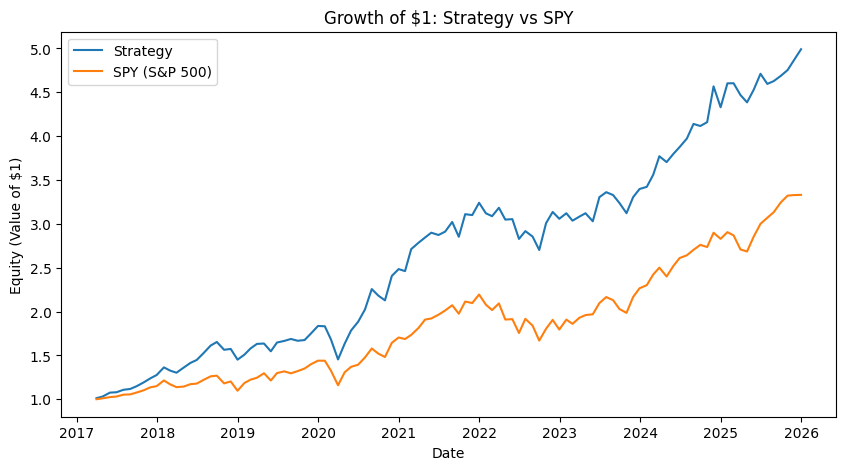

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(combined.index, combined["strategy"], label="Strategy")
plt.plot(combined.index, combined["spy"], label="SPY (S&P 500)")
plt.title("Growth of $1: Strategy vs SPY")
plt.ylabel("Equity (Value of $1)")
plt.xlabel("Date")
plt.legend()
plt.show()


**Although our strategy looks really good, we have to think about survivorship bias.** The companies in our 'universe' are those that have survived til today. They haven't been aquired, merged, nor have they gone under. Thereby, the companies we're looking at are automatically 'safer' than other tickers.

To evaluate this strategy further, let's stress-test it by examining downside risk, specifically maximum drawdown, and by comparing its risk profile to a broad market benchmark like SPY.

In [ ]:
#Now we compute historical performance stats and max drawdown of our strat and SPY
from __future__ import annotations

from dataclasses import dataclass
import numpy as np
import pandas as pd


@dataclass(frozen=True)
class PerfStats:
    total_return: float
    cagr: float
    annual_vol: float
    max_drawdown: float


def compute_drawdown(equity: pd.Series) -> pd.Series:

    #Compute drawdown series from an equity curve.
    #Drawdown is measured as % drop from the running peak (<= 0).

    equity = equity.dropna()
    running_peak = equity.cummax()
    return (equity / running_peak) - 1.0


def compute_perf_stats(equity: pd.Series, periods_per_year: int = 252) -> PerfStats:

    #Compute basic performance stats from an equity curve.
    # Assumes equity is indexed by trading dates.

    equity = equity.dropna()
    if len(equity) < 2:
        raise ValueError("Equity series is too short to compute stats.")

    total_return = float(equity.iloc[-1] / equity.iloc[0] - 1.0)

    # Daily returns
    rets = equity.pct_change(fill_method=None).dropna()

    # Annualize using trading days
    num_years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = float((equity.iloc[-1] / equity.iloc[0]) ** (1 / num_years) - 1.0) if num_years > 0 else np.nan
    annual_vol = float(rets.std(ddof=0) * np.sqrt(periods_per_year))

    dd = compute_drawdown(equity)
    max_drawdown = float(dd.min())

    return PerfStats(
        total_return=total_return,
        cagr=cagr,
        annual_vol=annual_vol,
        max_drawdown=max_drawdown,
    )


strategy_equity: pd.Series = combined["strategy"].dropna()
spy_equity: pd.Series = combined["spy"].dropna()

# Align to common dates - gets rid of trading days where either SPY or our strategy doesn't have data
aligned = pd.concat(
    {"strategy": strategy_equity, "spy": spy_equity},
    axis=1
).dropna()

strategy_equity = aligned["strategy"]
spy_equity = aligned["spy"]

strategy_dd = compute_drawdown(strategy_equity)
spy_dd = compute_drawdown(spy_equity)

strategy_stats = compute_perf_stats(strategy_equity)
spy_stats = compute_perf_stats(spy_equity)

print("Strategy stats:", strategy_stats)
print("SPY stats:", spy_stats)

print("\nMax drawdown (Strategy):", f"{strategy_stats.max_drawdown:.2%}")
print("Max drawdown (SPY):     ", f"{spy_stats.max_drawdown:.2%}")


Strategy stats: PerfStats(total_return=3.925994456376105, cagr=0.1998193447599632, annual_vol=0.7225133645088615, max_drawdown=-0.20785718372977646)
SPY stats: PerfStats(total_return=2.326810873631346, cagr=0.1472036708722515, annual_vol=0.718439333446862, max_drawdown=-0.23927179858232017)

Max drawdown (Strategy): -20.79%
Max drawdown (SPY):      -23.93%


**This part is important... not only does our strategy have a slightly lower max drawdown, it also carries about the same volatility as SPY: we were able to *historically beat* the market CAGR by ~5%, with (pretty much) the same annualized volatility, meaning our ability to beat the market didn't come from taking on more risk.**

Take caution, though, because this still isn't conclusive evidence that 'we beat the market' or that we could in the future. It's highly optimistic and is likely influenced by factor crowding (especially post-COVID).

So, let's continue stress-testing with more realistic conditions, and let's factor in transaction costs, which we would incur under our strategy. Real portfolios incur costs when positions are changed. Monthly rebalancing requires selling stocks that no longer rank highly and buying new ones, which introduces transaction costs through bid–ask spreads, commissions, and market impact.

Ignoring these costs can materially overstate performance, especially for strategies with high turnover. By explicitly modeling transaction costs as a function of portfolio turnover, we test whether the strategy’s edge survives a conservative and realistic friction.

In [ ]:
import pandas as pd
import numpy as np


# ---------- Utilities ----------

def zscore(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / (s.std(ddof=0) + 1e-12)


def build_monthly_dates(
    trading_index: pd.DatetimeIndex,
    start: str = "2017-01-31"
) -> pd.Series:
    """
    Convert a daily trading index into month-end dates.
    """
    monthly = (
        pd.Series(trading_index)
        .groupby(trading_index.to_period("M"))
        .last()
    )
    return monthly[monthly >= start]


# ---------- Sentiment Stubs ----------

def sentiment_stub(ticker: str, asof_date: pd.Timestamp) -> float:
    return 0.0


# ---------- Scoring Function (v2) ----------

def score_universe_asof_v2(
    asof_date: pd.Timestamp,
    mom_3m: pd.DataFrame,
    mom_6m: pd.DataFrame,
    vol_3m: pd.DataFrame,
    ticker_to_sector: dict,
    top_n: int = 20,
    sentiment_fn=None,
    sentiment_threshold: float = -0.2,
) -> list[str]:
    """
    Rank stocks by sector-relative momentum with volatility penalty.
    Optionally filter using an external sentiment function.
    """

    rankable = mom_3m.loc[asof_date].dropna().index.tolist()
    if len(rankable) < top_n:
        return []

    df = pd.DataFrame({
        "ticker": rankable,
        "sector": [ticker_to_sector[t] for t in rankable],
        "mom_3m": mom_3m.loc[asof_date, rankable].values,
        "mom_6m": mom_6m.loc[asof_date, rankable].values,
        "vol_3m": vol_3m.loc[asof_date, rankable].values,
    }).dropna()

    df["mom3_z_sector"] = df.groupby("sector")["mom_3m"].transform(zscore)
    df["mom6_z_sector"] = df.groupby("sector")["mom_6m"].transform(zscore)
    df["vol_z"] = zscore(df["vol_3m"])

    df["QuantScore"] = (
        0.6 * df["mom3_z_sector"]
        + 0.4 * df["mom6_z_sector"]
        - 0.3 * df["vol_z"]
    )

    if sentiment_fn is not None:
        df["sentiment"] = df["ticker"].apply(
            lambda t: float(sentiment_fn(t, asof_date))
        )
        df = df[df["sentiment"] >= sentiment_threshold]

    return (
        df.sort_values("QuantScore", ascending=False)
          .head(top_n)["ticker"]
          .tolist()
    )


In [ ]:
def run_monthly_backtest_with_costs(
    adj_close: pd.DataFrame,
    mom_3m: pd.DataFrame,
    mom_6m: pd.DataFrame,
    vol_3m: pd.DataFrame,
    ticker_to_sector: dict,
    top_n: int = 20,
    start: str = "2017-01-31",
    cost_rate: float = 0.001,
    scorer=score_universe_asof_v2,
    sentiment_fn=sentiment_stub,
    sentiment_threshold: float = -0.2,
) -> pd.DataFrame:
    monthly_dates = build_monthly_dates(adj_close.index, start=start)

    rows = []
    prev_weights: dict[str, float] = {}

    for i in range(len(monthly_dates) - 1):
        asof_date = monthly_dates.iloc[i]
        next_date = monthly_dates.iloc[i + 1]

        tickers = scorer(
            asof_date=asof_date,
            mom_3m=mom_3m,
            mom_6m=mom_6m,
            vol_3m=vol_3m,
            ticker_to_sector=ticker_to_sector,
            top_n=top_n,
            sentiment_fn=sentiment_fn,
            sentiment_threshold=sentiment_threshold,
        )
        if len(tickers) < top_n:
            continue

        w = 1.0 / len(tickers)
        weights = {t: w for t in tickers}

        all_names = set(prev_weights) | set(weights)
        turnover = sum(abs(weights.get(t, 0.0) - prev_weights.get(t, 0.0)) for t in all_names)

        start_prices = adj_close.loc[asof_date, tickers]
        end_prices = adj_close.loc[next_date, tickers]
        gross_ret = float((end_prices / start_prices - 1.0).mean())

        cost_paid = cost_rate * turnover
        net_ret = gross_ret - cost_paid

        rows.append({
            "date": next_date,
            "gross_return": gross_ret,
            "turnover": turnover,
            "cost_paid": cost_paid,
            "net_return": net_ret,
        })

        prev_weights = weights

    # ---- NEW: gracefully handle "no trades / no rows" case ----
    if not rows:
        empty = pd.DataFrame(
            columns=["gross_return", "turnover", "cost_paid", "net_return", "gross_equity", "net_equity"],
            index=pd.DatetimeIndex([], name="date"),
        )
        return empty
    # ----------------------------------------------------------

    bt_cost = pd.DataFrame(rows).set_index("date").sort_index()
    bt_cost["gross_equity"] = (1.0 + bt_cost["gross_return"]).cumprod()
    bt_cost["net_equity"] = (1.0 + bt_cost["net_return"]).cumprod()
    return bt_cost



bt_cost = run_monthly_backtest_with_costs(
    adj_close=adj_close,
    mom_3m=mom_3m,
    mom_6m=mom_6m,
    vol_3m=vol_3m,
    ticker_to_sector=ticker_to_sector,
    top_n=20,
    start="2017-01-31",
    cost_rate=0.001,
)

bt_cost.tail()


,gross_return,turnover,cost_paid,net_return,gross_equity,net_equity
date,,,,,,
2025-09-30,0.012934,0.9,0.0009,0.012034,4.671976,4.273135
2025-10-31,0.014073,0.9,0.0009,0.013173,4.737724,4.329424
2025-11-28,0.023086,1.0,0.0010,0.022086,4.847097,4.425042
2025-12-31,0.026316,1.1,0.0011,0.025216,4.974651,4.536622
2026-01-08,0.048579,0.8,0.0008,0.047779,5.216317,4.753379


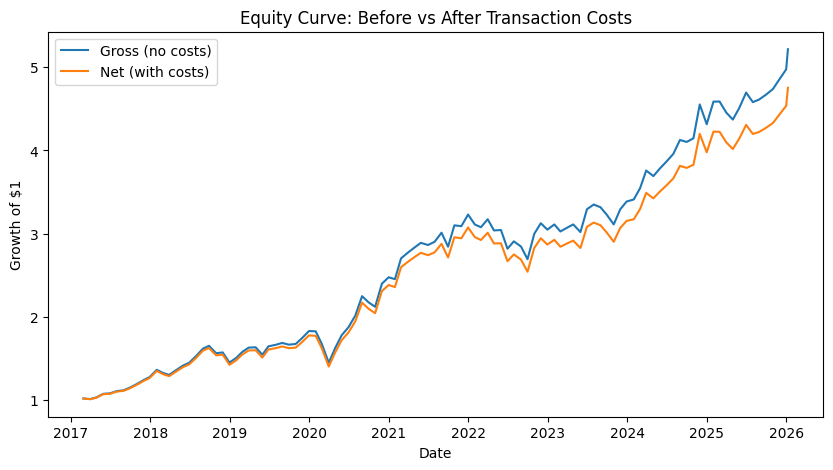

,turnover,cost_paid
count,108.000000,108.000000
mean,0.872222,0.000872
std,0.194712,0.000195
min,0.300000,0.000300
25%,0.700000,0.000700
50%,0.900000,0.000900
75%,1.000000,0.001000
max,1.300000,0.001300


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(bt_cost.index, bt_cost["gross_equity"], label="Gross (no costs)")
plt.plot(bt_cost.index, bt_cost["net_equity"], label="Net (with costs)")
plt.title("Equity Curve: Before vs After Transaction Costs")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.show()

bt_cost[["turnover","cost_paid"]].describe()


To verify that the strategy’s performance is not simply due to market drift or favorable sample selection, we can compare it against a 'placebo' strategy that randomly selects stocks from the same investable universe each month.

If the strategy’s logic contains genuine information, it should consistently outperform this randomized baseline over time. If not, similar performance would suggest that the apparent edge is largely coincidental.

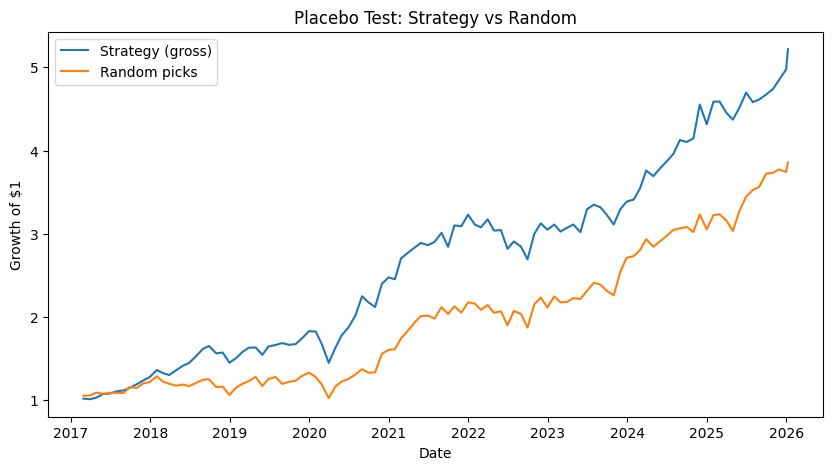

In [ ]:
def run_random_backtest(
    adj_close: pd.DataFrame,
    mom_3m: pd.DataFrame,   # only used to define "rankable" set per date
    top_n: int = 20,
    start: str = "2017-01-31",
    seed: int = 42,
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    monthly_dates = build_monthly_dates(adj_close.index, start=start)

    rows = []
    for i in range(len(monthly_dates) - 1):
        asof_date = monthly_dates.iloc[i]
        next_date = monthly_dates.iloc[i+1]

        rankable = mom_3m.loc[asof_date].dropna().index.tolist()
        if len(rankable) < top_n:
            continue

        picks = rng.choice(rankable, size=top_n, replace=False).tolist()

        gross_ret = float((adj_close.loc[next_date, picks] / adj_close.loc[asof_date, picks] - 1.0).mean())
        rows.append({"date": next_date, "return": gross_ret})

    bt_rand = pd.DataFrame(rows).set_index("date").sort_index()
    bt_rand["equity"] = (1.0 + bt_rand["return"]).cumprod()
    return bt_rand

bt_rand = run_random_backtest(adj_close, mom_3m, top_n=20, start="2017-01-31", seed=7)

plt.figure(figsize=(10,5))
plt.plot(bt_cost.index, bt_cost["gross_equity"], label="Strategy (gross)")
plt.plot(bt_rand.index, bt_rand["equity"], label="Random picks")
plt.title("Placebo Test: Strategy vs Random")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.show()


Only after establishing that the core strategy is robust under stress tests does it make sense to introduce additional complexity.

**This is where Natural Language Processing (NLP) Comes In:**

Rather than using NLP to directly “pick stocks,” we frame emotional or sentimental signals as a complement to our strategy's ability to manage risk and regime shifts that are not captured by price-based momentum alone.

In the next section, we explore how qualitative information—such as news sentiment and narrative risk—can be integrated to refine portfolio construction and potentially mitigate drawdowns without relying on hindsight or discretionary judgment. For example, we could use it to flag earnings, measure sentiment, suppress positions when narrative risk spikes, reduce exposure before large drawdowns, and detect litigation, regulatory, or fraud language.

In [ ]:
#WE WILL BE USING FinBert FOR OUR SENTIMENT DATA
!pip -q install transformers torch sentencepiece feedparser



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd

FINBERT_MODEL = "ProsusAI/finbert"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

_tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
_model = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL).to(device)
_model.eval()

LABELS = ["negative", "neutral", "positive"]

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os, json, time, re
import feedparser

CACHE_DIR = "nlp_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def _cache_path(key: str) -> str:
    safe = re.sub(r"[^a-zA-Z0-9_.-]+", "_", key)
    return os.path.join(CACHE_DIR, safe + ".json")

def fetch_google_news_rss(query: str, max_items: int = 40, sleep_s: float = 0.5):
    url = f"https://news.google.com/rss/search?q={query}&hl=en-US&gl=US&ceid=US:en"
    feed = feedparser.parse(url)
    items = []
    for entry in feed.entries[:max_items]:
        items.append({
            "title": getattr(entry, "title", ""),
            "published": getattr(entry, "published", ""),
            "link": getattr(entry, "link", ""),
        })
    time.sleep(sleep_s)
    return items

def get_headlines_cached(query: str, asof_date: pd.Timestamp, max_items: int = 40):
    key = f"rss_{query}_{asof_date.date()}_{max_items}"
    path = _cache_path(key)
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    headlines = fetch_google_news_rss(query=query, max_items=max_items)
    with open(path, "w") as f:
        json.dump(headlines, f)
    return headlines

def finbert_scores_batch(texts: list[str]) -> np.ndarray:
    if not texts:
        return np.array([])

    inputs = _tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=64,
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = _model(**inputs).logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()
    scores = probs[:, LABELS.index("positive")] - probs[:, LABELS.index("negative")]
    return scores


_SENTIMENT_MONTH_CACHE = {}

def get_monthly_sentiment_finbert_cached(
    ticker: str,
    asof_date: pd.Timestamp,
    max_items: int = 40,
) -> float:
    key = (ticker, asof_date.to_period("M"))
    if key in _SENTIMENT_MONTH_CACHE:
        return _SENTIMENT_MONTH_CACHE[key]

    headlines = get_headlines_cached(
        query=ticker,
        asof_date=asof_date,
        max_items=max_items,
    )

    titles = [h.get("title", "") for h in headlines if h.get("title")]
    if not titles:
        _SENTIMENT_MONTH_CACHE[key] = 0.0
        return 0.0

    scores = finbert_scores_batch(titles)
    score = float(np.mean(scores)) if len(scores) else 0.0

    _SENTIMENT_MONTH_CACHE[key] = score
    return score


In [ ]:
bt_nlp = run_monthly_backtest_with_costs(
    adj_close=adj_close,
    mom_3m=mom_3m,
    mom_6m=mom_6m,
    vol_3m=vol_3m,
    ticker_to_sector=ticker_to_sector,
    top_n=20,
    start="2017-01-31",
    cost_rate=0.001,
    sentiment_fn=get_monthly_sentiment_finbert_cached,
    sentiment_threshold=-0.2,
)

print("Rows produced with FinBERT:", len(bt_nlp))
bt_nlp.tail()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(bt_cost.index, bt_cost["net_equity"], label="Baseline (stub)")
plt.plot(bt_nlp.index, bt_nlp["net_equity"], label="With FinBERT filter")
plt.title("Net Equity: Baseline vs FinBERT Sentiment Filter")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.show()
